### Quantum walks example

In [1]:
import pennylane as qml 
import numpy as np 

/Users/venkat/opt/anaconda3/envs/QCML/lib/python3.9/site-packages/pennylane/ops/op_math/controlled.py:253: UserWarning: Specifying control values as a string is deprecated. Please use Sequence[Bool]
  warnings.warn(


tensor([0.25, 0.25, 0.25, 0.25], requires_grad=True)

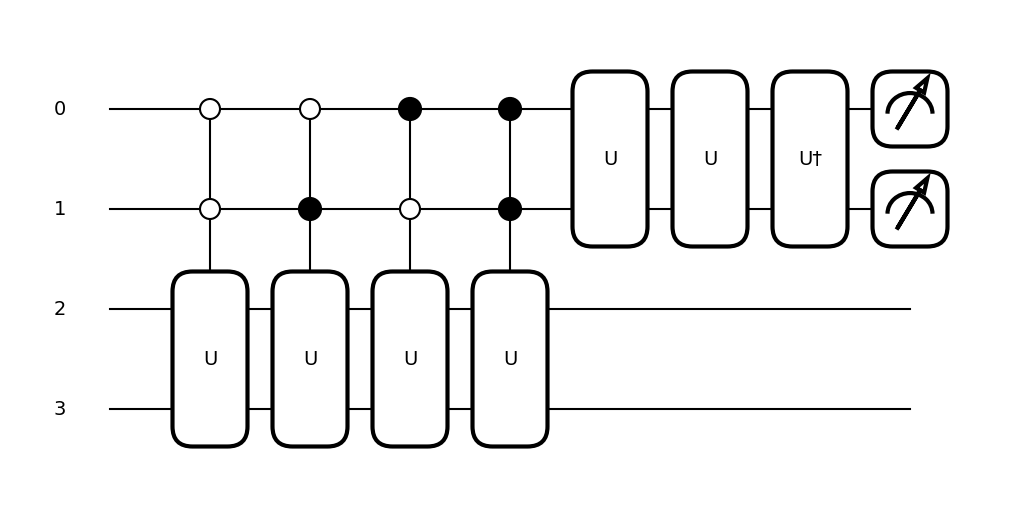

In [9]:
k_bits = 2 # number of bits in the O register
main_bits = 2 # number of bits in the main register
all_bits = k_bits + main_bits # total number of bits

# define wire ranges for each of the three registers
k_wires = range(k_bits) # O register
main_wires = range(k_bits, all_bits) # main register
dev = qml.device("default.qubit", wires=all_bits)  

def householder(state):
    o = 2 * np.outer(state, state)
    return np.eye(o.shape[0]) - o

def PREPARE(alpha_list):
    zero_vec = np.array([1] + [0]*(2**k_bits - 1))
    alpha_list = alpha_list/np.linalg.norm(alpha_list)
    return householder(zero_vec - alpha_list)

def SELECT(U_list):
    for index in range(2**k_bits):
        ctrl_str = np.binary_repr(index, k_bits) # Create binary representation
        qml.ControlledQubitUnitary(U_list[index], control_wires=k_wires, 
                                   wires=main_wires, control_values=ctrl_str)

U_list = [np.kron(qml.PauliX.compute_matrix(), qml.PauliX.compute_matrix()),
          np.kron(qml.PauliZ.compute_matrix(), qml.PauliZ.compute_matrix()),
          np.kron(qml.PauliX.compute_matrix(), qml.PauliZ.compute_matrix()),
          np.kron(qml.PauliZ.compute_matrix(), qml.PauliX.compute_matrix())]

alpha_list = [1, 1, 1, 1]

@qml.qnode(dev)
def walk(alpha_list, U_list):
    R = -1 * np.eye(2**k_bits)
    R[0][0] = 1
    SELECT(U_list)
    U = PREPARE(alpha_list)
    qml.QubitUnitary(U, wires=k_wires)
    qml.QubitUnitary(R, wires=k_wires)
    qml.adjoint(qml.QubitUnitary(U, wires=k_wires))
    return qml.probs(wires=k_wires)
    
qml.draw_mpl(walk)(alpha_list, U_list)
